In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, \
  BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [2]:
# Load in the data
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Scale data
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1
print(x_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


In [3]:
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [4]:
latent_dim = 100

In [5]:
# Make generator model
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model

In [6]:
# Build discriminator model
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model

In [8]:
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy']
)

generator = build_generator(latent_dim)
z = Input(shape=(latent_dim,))
img = generator(z)

discriminator.trainable = False
fake_pred = discriminator(img)
combined_model = Model(z, fake_pred)
combined_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5)
)

In [9]:
# Train GAN
batch_size = 32
epochs = 30000
sample_period = 200 

ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Losses
d_losses = []
g_losses = []

if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [10]:
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  # Rescale images
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

In [11]:
# Main train loop
for epoch in range(epochs):
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]
  
  # Generate fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)
  
  # Train the discriminator
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)

  # Train generator
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)
  
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)
  
  # Save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)
  
  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
      d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  
  if epoch % sample_period == 0:
    sample_images(epoch)

epoch: 1/30000, d_loss: 1.09,       d_acc: 0.36, g_loss: 0.87
epoch: 101/30000, d_loss: 0.03,       d_acc: 1.00, g_loss: 3.86
epoch: 201/30000, d_loss: 0.47,       d_acc: 0.72, g_loss: 1.61
epoch: 301/30000, d_loss: 0.71,       d_acc: 0.47, g_loss: 0.62
epoch: 401/30000, d_loss: 0.70,       d_acc: 0.45, g_loss: 0.65
epoch: 501/30000, d_loss: 0.70,       d_acc: 0.47, g_loss: 0.67
epoch: 601/30000, d_loss: 0.69,       d_acc: 0.47, g_loss: 0.67
epoch: 701/30000, d_loss: 0.69,       d_acc: 0.50, g_loss: 0.67
epoch: 801/30000, d_loss: 0.67,       d_acc: 0.52, g_loss: 0.71
epoch: 901/30000, d_loss: 0.68,       d_acc: 0.56, g_loss: 0.70
epoch: 1001/30000, d_loss: 0.70,       d_acc: 0.50, g_loss: 0.73
epoch: 1101/30000, d_loss: 0.65,       d_acc: 0.64, g_loss: 0.74
epoch: 1201/30000, d_loss: 0.68,       d_acc: 0.55, g_loss: 0.73
epoch: 1301/30000, d_loss: 0.68,       d_acc: 0.56, g_loss: 0.75
epoch: 1401/30000, d_loss: 0.69,       d_acc: 0.55, g_loss: 0.76
epoch: 1501/30000, d_loss: 0.68,     

In [12]:
!ls gan_images

0.png	   13800.png  17800.png  21600.png  25600.png  29600.png  6600.png
10000.png  14000.png  18000.png  21800.png  25800.png  29800.png  6800.png
1000.png   1400.png   1800.png	 22000.png  26000.png  3000.png   7000.png
10200.png  14200.png  18200.png  2200.png   2600.png   3200.png   7200.png
10400.png  14400.png  18400.png  22200.png  26200.png  3400.png   7400.png
10600.png  14600.png  18600.png  22400.png  26400.png  3600.png   7600.png
10800.png  14800.png  18800.png  22600.png  26600.png  3800.png   7800.png
11000.png  15000.png  19000.png  22800.png  26800.png  4000.png   8000.png
11200.png  15200.png  19200.png  23000.png  27000.png  400.png	  800.png
11400.png  15400.png  19400.png  23200.png  27200.png  4200.png   8200.png
11600.png  15600.png  19600.png  23400.png  27400.png  4400.png   8400.png
11800.png  15800.png  19800.png  23600.png  27600.png  4600.png   8600.png
12000.png  16000.png  20000.png  23800.png  27800.png  4800.png   8800.png
1200.png   1600.png   2000.png

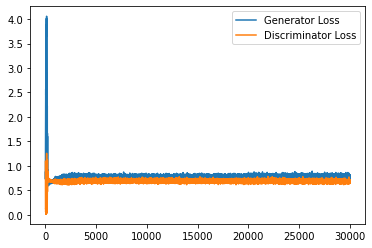

In [14]:
# Plot loss of the generator and the discriminator
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.legend()

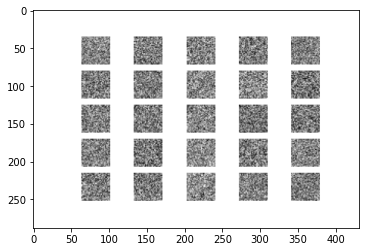

In [16]:
from skimage.io import imread
img1 = imread('gan_images/0.png')
plt.imshow(img1) # first image made by AI

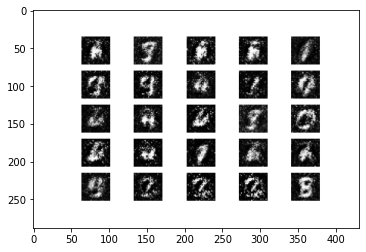

In [17]:
img2 = imread("gan_images/1000.png")
plt.imshow(img2)  # a bit into training

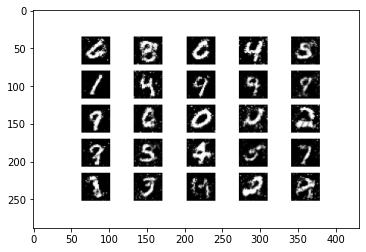

In [18]:
img3 = imread("gan_images/5000.png")
plt.imshow(img3) # a bit after that

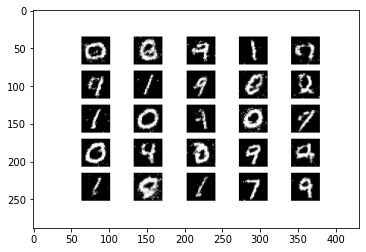

In [19]:
img4 = imread('gan_images/10000.png')
plt.imshow(img4) # well into training

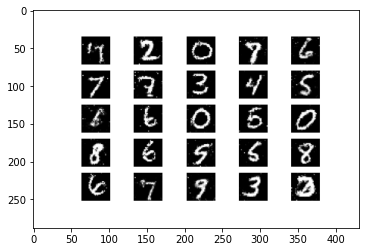

In [20]:
img5 = imread('gan_images/29800.png')
plt.imshow(img5) # last image